In [1]:
# do JULIA_NUM_THREAD=36 or 64 or 50  before starting jupyter lab
using DifferentialEquations;
using Plots;
#using Interpolations;

using ParameterizedFunctions;
using DataFrames;
using PyPlot;
using Dierckx;
using Base.Threads;
using CSV;
using JLD2;
using ProgressMeter;
# https://github.com/timholy/ProgressMeter.jl
# does not work



In [2]:
Threads.nthreads()


50

In [3]:
VERSION

v"1.4.1"

In [4]:
M(t, n) = mod(n*t, 2pi);
Ta(E::Float64, e::Float64) = 2* atan(sqrt((1 + e)/(1 - e))* sin(E/2.),cos(E/2.))


Ta (generic function with 1 method)

In [5]:
# Read http://murison.alpheratz.net/dynamics/twobody/KeplerIterations_summary.pdf
# Solve M = y - esin(y)

function KeplerStart3(e::Float64, M::Float64)
    t34=e*e
    t35 = e*t34
    t33= cos(M)
    M+(-.5*t35+e+(t34+1.5*t33*t35)*t33)*sin(M);
end


function eps3(e::Float64,M::Float64,x::Float64)

    t1 = cos(x);
    t2 = -1+e*t1;
    t3 = sin(x);
    t4 = e*t3;
    t5 = -x+t4+M;
    t6 = t5/(.5*t5*t4/t2+t2);
    t5/((.5*t3 - 1.0/6*t1*t6)*e*t6+t2);
end;



function KeplerSolve( e::Float64, M::Float64)#; tol=1.0e-14 )
    tol=1.5e-14
    Mnorm = mod(M,2π)
    E0 = KeplerStart3(e,Mnorm);
    dE = tol + 1.0;
    count = 0;
    E = E0;
    while dE > tol 
        E = E0 - eps3(e,Mnorm,E0);
        dE = abs(E-E0);
        E0 = E;
        count = count + 1;
        if count >10
            return E
        end
      
    end
    return E#,count
end 


KeplerSolve (generic function with 1 method)

In [6]:



g = @ode_def_bare begin
    #zz = KeplerSolve(e, n*t);
   
    dx = -3.0/2.0*n^2*σ/((1.0 - e*cos(   KeplerSolve(e, n*t)   ))^3.0)*(sin(2*y - 2*Ta( KeplerSolve(e, n*t)     , e))) 
    dy = x # x - velocity, y - angle
end n σ e;



In [7]:
struct ModelParam
    n::Float64
    σ::Float64
    e::Float64
end;

struct SolveParamsG
    #ninterp::Int32 # number in interpolating reverse function -- should it be Int64? unused -- done above
    eps_abs::Float64
    eps_rel::Float64 #Eps for ODE
    om1n::Float64
    om2n::Float64
    n_omega::Int64
    n_phase::Int64
end



function ensmbl_solve(mp::ModelParam,omega::Array{Float64,1},phase_p::Array{Float64,1}; eps_rel, eps_abs)
    T = 2*π/mp.n; 
    u0 = [200.0*mp.n, 0]
    p =  [mp.n mp.σ mp.e ]
    prob11 = ODEProblem(g, u0,(-T/2,T/2), p)
    
    progress = Progress(length(phase_p),1)
    
    function output_sol4(sol,i)
        om1 = sol.u[1][1]
        om2 = sol.u[end][1]
        delta_phase = sol.u[end][2] - sol.u[1][2] -T*(om1+om2)/2.0
        next!(progress)
        [phase_p[i], om1, om2 - om1, delta_phase],false # omega, delta_omega, phase0, delta_phase
    end
    
    function prob_func_gr(prob,i,repeat)
        ph0 = -T/2.0*omega[i]
        @. prob.u0 =  [ omega[i], phase_p[i]+ph0]
        prob
    end

    ensemble_prob = EnsembleProblem(prob11,prob_func=prob_func_gr, output_func = output_sol4)
    sim_grid = solve(ensemble_prob,AutoTsit5(Rosenbrock23()),EnsembleThreads(),
        trajectories=length(phase_p),
        reltol=eps_rel,
        abstol=eps_abs,
        maxiters = 10000000, saveat=(-T/2,T/2)

    );
    
    hcat(sim_grid...)' # transform into 2d array
end;


function grid_solve(mp::ModelParam, spar::SolveParamsG)
    nph = spar.n_phase
    nvel = spar.n_omega
    phase_p = zeros(nph*nvel)
    omega = zeros(nph*nvel)
    for i =1:nph
        for j = 1:nvel
            indx = (i-1)*nvel+j
            phase_p[indx] = ((i-1)/(nph-1.0))*pi 
            omega[indx] = ((j-1)/(nvel-1))*(spar.om2n - spar.om1n) + spar.om1n
        end
    end
    # Make much finer grid at omega -> 0??
    ensmbl_solve(mp, omega, phase_p; eps_rel = spar.eps_rel, eps_abs = spar.eps_abs );
   
end;

In [8]:
# For HY51 max omega: 1000n, enough,. We had SolveParamsG(1e-12,1e-12,-model_params.n*1000, model_params.n*1600, 3501, 151) 
# for ecc==0.98: go to 2000 at least. sp = SolveParamsG(1e-12,1e-12,-model_params.n*1000, model_params.n*2300, 5001, 151) 
    
eccentricity=0.9684
# HY51 period is 4.17 years
# assume non-sphericity (b-a)/a=0.2 
model_params = ModelParam(2*pi/4.17/365.25,0.2,eccentricity)
#sp = SolveParamsG(1e-12,1e-12,-model_params.n*5000, model_params.n*10000, 21001, 151) # for 0.99 calculate bigger grid
sp = SolveParamsG(1e-12,1e-12,-model_params.n*1000, model_params.n*1600, 10001, 151) # 
# filling space from -1000 to 1600 n`
# this is possibly an overkill
# Use a less fine grid if you do not have a beefy server to run it. 

grid_solution = grid_solve(model_params, sp);

Progress: 100%|█████████████████████████████████████████| Time: 0:36:38


In [9]:


@save "Data/HY51_1.jld2" model_params sp grid_solution
# when one needs them again:
#@load "Data/HY51_1.jld2" model_params sp grid_solution 

# The solutions of differential equations are saved and interpolated. You should be able to do long term chaotic drift simulations without resolving ODEs. 

In [10]:
model_params

ModelParam(0.004125281496153114, 0.2, 0.9684)

In [11]:


function model_orbit(mp::ModelParam, sp::SolveParamsG, grd_sol::Array{Float64,2}; Norb::Int64,om1::Float64,ph1::Float64, 
        om_width::Float64=0.004, # Width it may be stuck in
        delta::Float64=1e-4 ,
        Nstuck::Int64=10_000)
    # gdr_sol is N by 4 array generated by grid_solve
    # Detects if stuck in a resonance and stays in a small (2*width) interval 
    # In which case returns early
    
    
    deltav2d = reshape(grd_sol[:,3], (sp.n_omega, sp.n_phase));
    phase2d = reshape(grd_sol[:,1], (sp.n_omega, sp.n_phase));
    omega2d = reshape(grd_sol[:,2], (  sp.n_omega, sp.n_phase));
    delta_phase2d = reshape(grd_sol[:,4], (  sp.n_omega, sp.n_phase));
    
    omega_spl = omega2d[:,1]
    phs_spl = phase2d[1,:]

    spl_delta_omega = Spline2D(omega_spl, phs_spl, deltav2d)
    spl_delta_phase = Spline2D(omega_spl, phs_spl, delta_phase2d);
    
    T = 2π/mp.n


    om = zeros(Norb)
    ph = zeros(Norb)
  
   
    om[1] = om1
    ph[1]=ph1
    
    stuck = false
    
    om_curr  = om1
    count_stuck = 0
    
    for i=2:Norb
        ph_peri = ph1 + T/2*om1
        ph_peri = mod(ph_peri,π)
        delta_om = evaluate(spl_delta_omega, om1,ph_peri)
        delta_phase = evaluate(spl_delta_phase, om1, ph_peri)
        om2 = om1 + delta_om
    
        ph2 = ph1+(om1+om2)*T/2 + delta_phase 
        ph2 = mod(ph2, 2π)
        #ph2 = rand()*2π
        om[i] = om2
        ph[i] = ph2
        
     
        
        if om2 > om_curr+om_width
            om_curr +=delta
            count_stuck=0
        elseif om2 < om_curr - om_width
            om_curr -= delta
            count_stuck=0
        
        else 
            count_stuck+=1
        end
        
        if (count_stuck > Nstuck) 
             # detecting stuck 
            om = om[1:i]
            ph = ph[1:i]
            stuck = true
            break
        end;  
            
       
        om1 = om2
        ph1 = ph2
    end
    om,ph,stuck
end

model_orbit (generic function with 1 method)

In [12]:
# Sample orbit simulation 
Norb=50_000_000
@time om_, ph_ = model_orbit(model_params, sp, grid_solution[1:end, 1:end], Norb=Norb,om1=3.0,ph1=1.0+π,om_width = model_params.n*2, Nstuck=200_000, delta=1e-4);

177.176960 seconds (49.03 M allocations: 7.778 GiB, 1.42% gc time)


In [13]:
length(om_)

24266169

As you can see, the sim ended to be shorter than max of 50e6 orbits. 

Let's plot the end of sim, just as asteroid enters the resonance

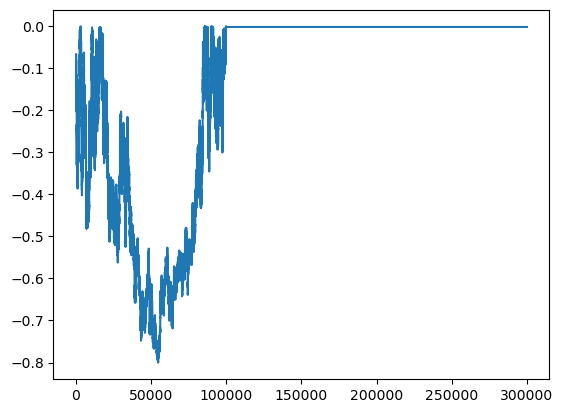

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4d15834df0>

In [14]:
PyPlot.plot(om_[end-300_000:end])

All of the sim

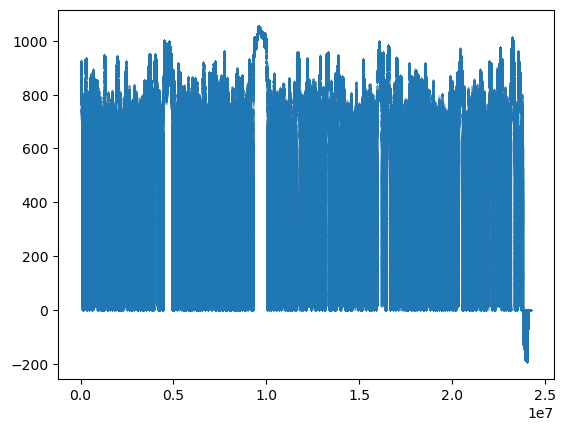

PyObject <matplotlib.collections.PathCollection object at 0x7f4bae9be7c0>

In [15]:
PyPlot.scatter(1:length(om_),om_./model_params.n,s=0.00005)

In [ ]:
# You can save this orbit for further analysis in a different package
#df9_trajectory = DataFrame(omega_over_n= om_/model_params.n, phase = ph_)
#CSV.write("df_e09_s02_traj.csv", df9_trajectory)

In [16]:
function model_orbit_nomem(mp::ModelParam, sp::SolveParamsG, grd_sol::Array{Float64,2}; Norb::Int64,om1::Float64,ph1::Float64, 
        om_width::Float64=0.004, # Width it may be stuck in
        delta::Float64=1e-4 ,
        Nstuck::Int64=10_000 )
    # Similar to previous orbit simulation, but it does not return intermediate omega at each orbit, only number of orbits 
    # and final and max  rotation speed
    
    # gdr_sol is N by 4 array generated by grid_solve
    
    deltav2d = reshape(grd_sol[:,3], (sp.n_omega, sp.n_phase));
    phase2d = reshape(grd_sol[:,1], (sp.n_omega, sp.n_phase));
    omega2d = reshape(grd_sol[:,2], (  sp.n_omega, sp.n_phase));
    delta_phase2d = reshape(grd_sol[:,4], (  sp.n_omega, sp.n_phase));
    
    omega_spl = omega2d[:,1]
    phs_spl = phase2d[1,:]

    spl_delta_omega = Spline2D(omega_spl, phs_spl, deltav2d)
    spl_delta_phase = Spline2D(omega_spl, phs_spl, delta_phase2d);
    
    T = 2π/mp.n


    n_done = Norb
    om2=0.0::Float64
    ph2 = 0.0::Float64
    
    om_curr  = om1
    count_stuck = 0
    
    om_max = om1
    om_min = om1
    
    stuck = false
    
    for i=2:Norb
        ph_peri = ph1 + T/2*om1
        ph_peri = mod(ph_peri,π)
        delta_om = evaluate(spl_delta_omega, om1,ph_peri)
        delta_phase = evaluate(spl_delta_phase, om1, ph_peri)
        om2 = om1 + delta_om
    
        ph2 = ph1+(om1+om2)*T/2 + delta_phase 
        ph2 = mod(ph2, 2π)
        #ph2 = rand()*2π
        
        if om2>om_max 
            om_max = om2
        elseif om2 < om_min
            om_min = om2
        end;
        
        if om2 > om_curr+om_width
            om_curr +=delta
            count_stuck=0
        elseif om2 < om_curr - om_width
            om_curr -= delta
            count_stuck=0
        
        else 
            count_stuck+=1
        end
        
        if count_stuck > Nstuck
            n_done = i
            stuck = true
            break
        end;  
            
        
        om1 = om2
        ph1 = ph2
    end
    om2,ph2,stuck, n_done, om_max, om_min
end

model_orbit_nomem (generic function with 1 method)

In [17]:

Norb=50_000_000
@time om2, ph2, stuck, n_done,om_max, om_min = model_orbit_nomem(model_params, sp, grid_solution[1:end, 1:end], 
    Norb=Norb,om1=3.0,ph1=1.0+π,om_width = model_params.n, delta = 1e-4);

 70.936172 seconds (19.56 M allocations: 2.753 GiB, 0.65% gc time)


In [18]:
n_done

9729664

In [19]:
om_max, maximum(om_)

(4.345350573231109, 4.345350573231109)

In [ ]:
#maximum(om_[end-100:end])-om2, minimum(om_[end-100:end])-om2

#PyPlot.plot(om_[end-100:end].-om2)

In [20]:
#@elapsed 
function run_resonance_sims( mp,sp, grid_sol;ntry=48::Int64,Norb=10_000_000::Int64)
    df = DataFrame(
        omstart=zeros(ntry), 
        omfinal=zeros(ntry), 
        ommax=zeros(ntry), 
        ommin=zeros(ntry), 
        phstart=zeros(ntry), 
        phfinal=zeros(ntry),
        n_orb = zeros(Int64,ntry),
        stuck = zeros(Int64, ntry))

    progress = Progress(ntry,1)
    @threads for i=1:ntry
        omstart = rand()*4
        phstart = rand()*π
    
        om2, ph2, stuck, n_done,om_max, om_min  = model_orbit_nomem(mp, sp, grid_sol[1:end, 1:end], Norb=Norb,om1=omstart,ph1=phstart,om_width = mp.n*2, Nstuck = 200_000, delta=1e-4);
        df.omstart[i] = omstart/mp.n
        df.omfinal[i] =  om2/mp.n
        df.phstart[i] = phstart
        df.phfinal[i] = ph2
        df.n_orb[i] = n_done
        df.stuck[i] = stuck
        df.ommax[i] = om_max/mp.n
        df.ommin[i] = om_min/mp.n
        next!(progress)
        #print(i,"\n")
    end;

    df
end

run_resonance_sims (generic function with 1 method)

In [ ]:
#df_1 = df
# Run simulation for 5000 different starting conditions, the sime should not exceed 250e6 orbit -- 1 GY approximately
df=run_resonance_sims(model_params,sp,grid_solution, ntry=5000,Norb=250_000_000);

Progress:  29%|████████████                             |  ETA: 16:10:0919m

In [ ]:
#@time df=run_resonance_sims(model_params,sp,grid_solution, ntry=5000,Norb=250_000_000)

In [23]:
minimum(df.ommin)

-304.8241741459298

In [22]:
maximum(df.ommax)

1100.2239625532638

In [14]:
maximum(df.ommax)

968.6766366698337

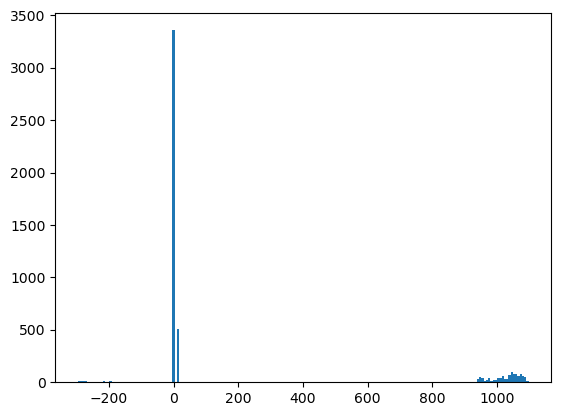

In [24]:
PyPlot.hist(df.omfinal, bins=200);

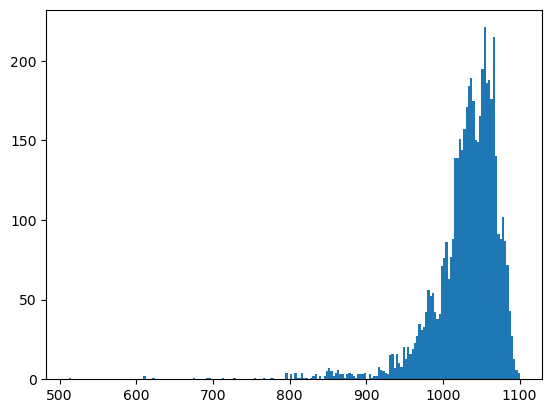

In [25]:
PyPlot.hist(df.ommax, bins=200);

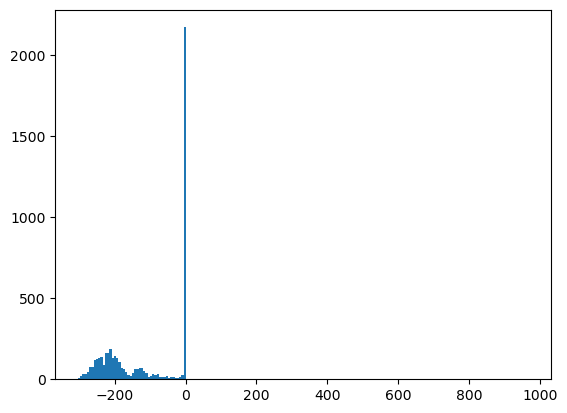

In [26]:
PyPlot.hist(df.ommin, bins=200);

The grid was from -1000n to 1600n, so we are covered. 

In [27]:
# Study those that are not stuck
#CSV.write("Resonance_sim_1_5000_e08_250e6.csv", df)
sum(df.stuck)

5000

All trajectories ended in a resonance.

In [28]:
#df=CSV.read("Resonance_sim_1_5000_e09_250e6.csv")
df

,omstart,omfinal,ommax,ommin,phstart,phfinal,n_orb,stuck
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,469.272,1033.02,1040.37,0.0196384,3.09029,5.68129,3335549,1
2,299.338,-0.516312,1048.31,-248.756,2.67338,4.71306,22490769,1
3,409.81,-0.262766,1045.86,-209.294,1.93289,0.781111,39144762,1
4,360.593,-0.253976,1061.76,-98.8277,1.54664,5.46686,21371429,1
5,649.496,-0.262766,1059.17,-208.811,1.70279,0.781111,37228542,1
6,162.158,-0.516312,930.65,-1.26049,2.63464,1.57146,1783480,1
7,81.5553,-0.516312,1064.25,-159.707,1.64584,4.71306,21377535,1
8,439.702,-0.262766,1071.34,-223.302,1.36868,0.781111,18296986,1
9,396.669,-0.262766,971.967,-200.446,1.60388,3.9227,2108923,1


In [29]:
param =  df[26,:]

,omstart,omfinal,ommax,ommin,phstart,phfinal,n_orb,stuck
,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
26,473.623,1080.48,1082.25,0.0212795,2.21964,0.793397,14488979,1


In [30]:
# Check one of orbits
Norb_big = 50_000_000 
param =  df[26,:]
#param.omstart*mp_51.n

@time om_big,ph_big,stuck_big = model_orbit(model_params, sp, grid_solution[1:end, 1:end], Norb=Norb_big,om1=param.omstart*model_params.n,ph1=param.phstart*1.0,
    Nstuck=100_000);
    
  

116.959881 seconds (28.87 M allocations: 4.964 GiB, 1.59% gc time)


In [31]:
length(om_big)

14402494

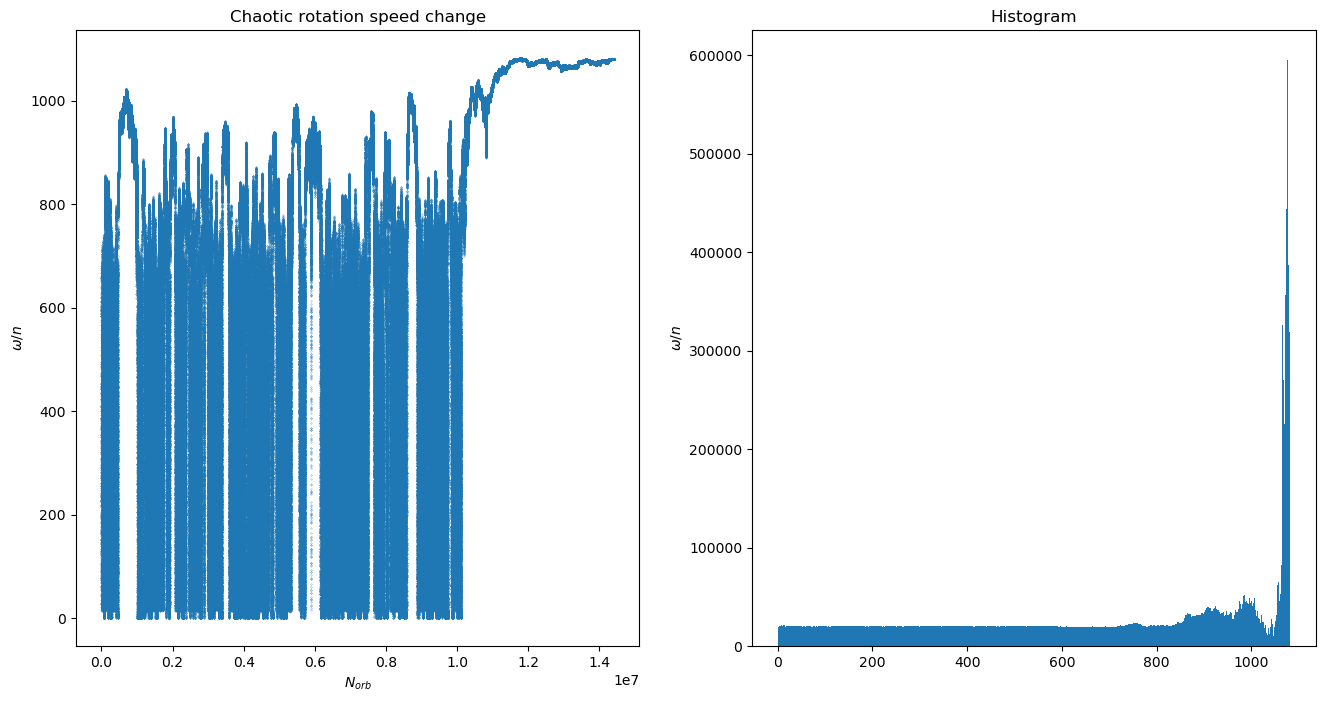

PyObject Text(0.5, 1, 'Histogram')

In [38]:
# one of trajectories -- omega and histogram (omega)
step = 10
start = 1
nmax = length(om_big) 
xr = start:step:nmax

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
#rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 10
fig = PyPlot.figure(figsize=(16,8)) # figsize=plt.figaspect(0.5)
ax_trj = fig.add_subplot(1, 2, 1)
ax_trj.scatter(xr,om_big[xr]/model_params.n, s=0.04)
ax_trj.set_xlabel(L"{N_{orb}}")
ax_trj.set_ylabel(L"{\omega/n}")
ax_trj.set_title("Chaotic rotation speed change")
ax_h = fig.add_subplot(1, 2, 2)
ax_h.hist(om_big[1:nmax]/model_params.n, bins=500);
ax_h.set_ylabel(L"{\omega}/n")
ax_h.set_title("Histogram")

#fig.savefig("Hist.png")

In [41]:
deltav2d = reshape(grid_solution[:,3], (sp.n_omega, sp.n_phase));
phase2d = reshape(grid_solution[:,1], (sp.n_omega, sp.n_phase));
omega2d = reshape(grid_solution[:,2], (  sp.n_omega, sp.n_phase));
delta_phase2d = reshape(grid_solution[:,4], (  sp.n_omega, sp.n_phase));

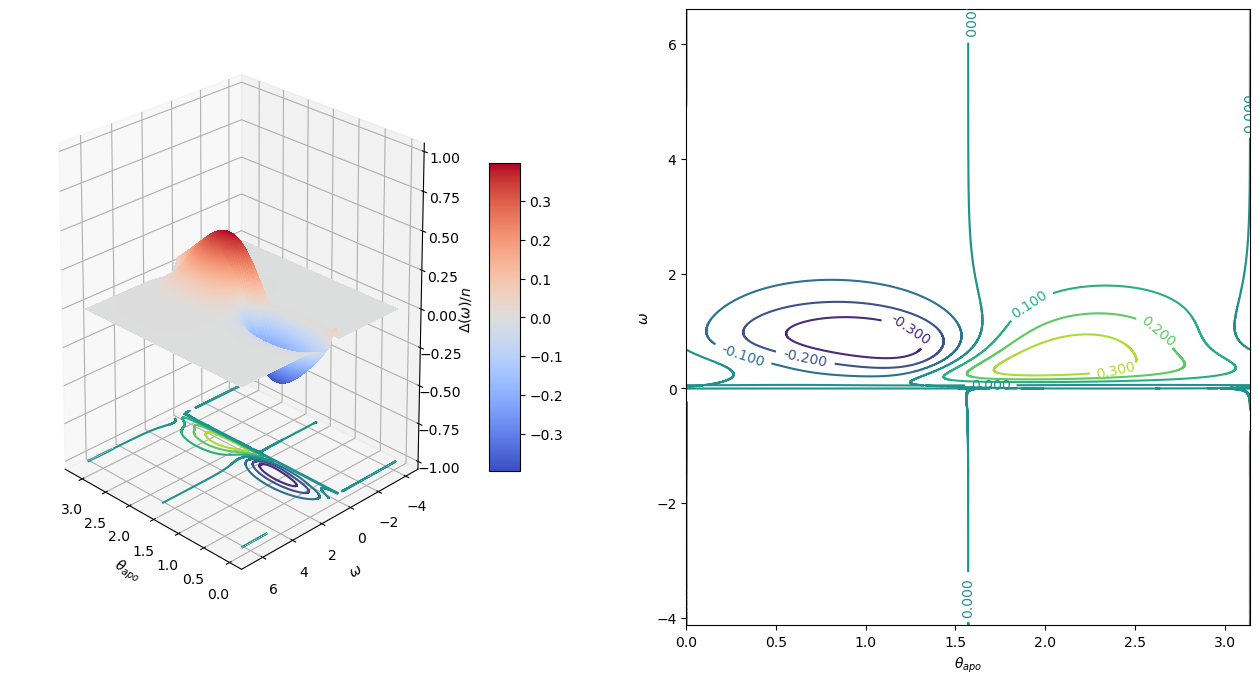

PyObject Text(650.5858585858584, 0.5, '${\\omega}$')

In [42]:
# change of omega during periastron passage for different omega and orientation

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
#rcParams = PyDict(matplotlib["rcParams"])
rcParams["font.size"] = 10
fig = PyPlot.figure(figsize=(16,8)) # figsize=plt.figaspect(0.5)
ax_s = fig.add_subplot(1, 2, 1, projection="3d")
surf_p = ax_s.plot_surface(phase2d,omega2d, deltav2d, rstride=1, cstride=1, cmap=PyPlot.cm.coolwarm,
                       linewidth=0, antialiased=false)

ax_s.view_init(elev=20., azim=135)
# ax_s.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
ax_s.set_zlim(-1.01, 1.01)
#ax_s.set_ylim(-.5, 2.1)
#ax_s.set_label("Y")
ax_s.set_xlabel(L"$\theta_{apo}$")
ax_s.set_ylabel(L"{\omega}")
ax_s.set_zlabel(L"\Delta\left(\omega\right)/n")
cset = ax_s.contour(phase2d,omega2d, deltav2d, offset=-1)#, cmap=PyPlot.cm.coolwarm), zdir='z
fig.colorbar(surf_p, shrink=0.5, aspect=10)

ax_c = fig.add_subplot(1, 2, 2)
CS = ax_c.contour(phase2d, omega2d, deltav2d)
#https://matplotlib.org/3.1.3/gallery/images_contours_and_fields/contour_label_demo.html?highlight=contour%20labels
ax_c.clabel(CS, CS.levels, inline=true,  fontsize=10), #fmt=fmt
#ax_c.set_ylim(-.5, 2.1)


ax_c.set_xlabel(L"$\theta_{apo}$")
ax_c.set_ylabel(L"{\omega}")
#PyPlot.savefig("deltaOmega_apoa.png")

In [44]:
T = 2π/model_params.n
p =  [model_params.n model_params.σ model_params.e ]
#u0 =  [ om_[end],ph_[end]]

u0 = [-0.144962*model_params.n,0.106019 ]

trange = ([0:1:1000;].-0.5).*T
prob1 = ODEProblem(g, u0,(trange[1], trange[end]), p)

#trange = range(-T/2, T/2, length = 10000)

@time sol1 = solve(prob1,Tsit5(),reltol=1e-13,abstol=1e-13,maxiters = 1000000000,saveat=trange);




  7.454320 seconds (6.66 M allocations: 338.151 MiB, 2.69% gc time)


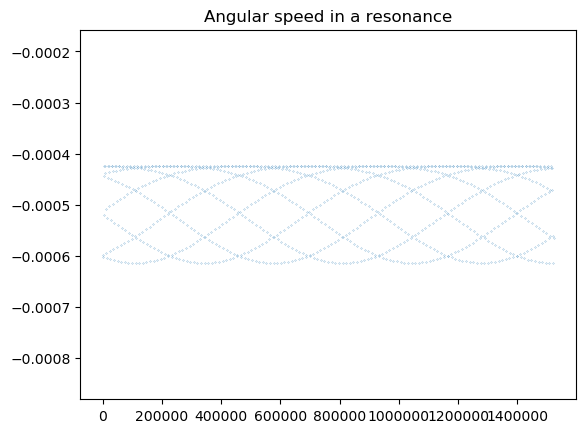

PyObject Text(0.5, 1, 'Angular speed in a resonance')

In [57]:
t = [sol1.t[i] for i in  1:length(sol1.t)]
u1 = [u[1] for u in sol1.u]
u2 = [mod(u[2], π) for u in sol1.u]
#u#2 = [u[1] for u in sol2.u[5000-nx:5000+nx]]
PyPlot.scatter(t, u1,s=0.03)
PyPlot.title("Angular speed in a resonance")

In [46]:
trange2 = ([0:1e-6:1;].-0.5).*T
prob2 = ODEProblem(g, u0,(trange2[1], trange2[end]), p)
@time sol2 = solve(prob2,Tsit5(),reltol=1e-13,abstol=1e-13,maxiters = 1000000000,saveat=trange2);

  0.287648 seconds (1.00 M allocations: 173.336 MiB)


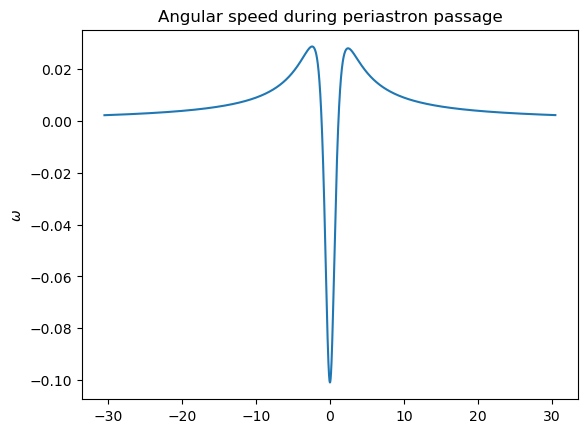

PyObject Text(0.5, 1, 'Angular speed during periastron passage')

In [56]:
t = [sol2.t[i] for i in  1:length(sol2.t)]
u1 = [u[1] for u in sol2.u]
u2 = [mod(u[2], π) for u in sol2.u]
nx = 20000
midt = Int(round(length(t)/2))
trng = (midt-nx):(midt+nx)
#PyPlot.scatter(t[trng], u1[trng],s=0.01)
PyPlot.plot(t[trng], u1[trng])
PyPlot.ylabel(L"{\omega}" )
PyPlot.title("Angular speed during periastron passage" )